In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
if not os.path.exists('data/gan_images'):
    os.makedirs('data/gan_images')

In [3]:
generator = models.Sequential()

# ReLu에 미세한 기울기를 지정?
generator.add(layers.Dense( 7 * 7 * 128, input_dim=100, activation=layers.LeakyReLU(0.2)))

# 전체 레이어를 고르게 정규화?
generator.add(layers.BatchNormalization()) 

# 1차원 -> 3차원?
generator.add(layers.Reshape((7, 7, 128)))

# MaxPooling과 정 반대인 느낌? 
generator.add(layers.UpSampling2D())

# (padding='same' 옵션 => 입력 이미지와 출력 이미지의 크기가 동일하도록)
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))

generator.add(layers.BatchNormalization()) 
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [4]:
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1),
                               padding='same'))

discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # 학습을 못하게 막음"?

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [5]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [6]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train = (X_train - 127.5)/ 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        noise = np.random.normal(0, 1,(batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch : %d' % i, 'd_loss: %.4f' % d_loss, 'g_loss : %.4f' % g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 118ms/step
epoch : 0 d_loss: 0.6993 g_loss : 0.8189
1/1 [==============================] - 0s 24ms/step
epoch : 1 d_loss: 0.3916 g_loss : 0.5359
1/1 [==============================] - 0s 21ms/step
epoch : 2 d_loss: 0.3385 g_loss : 0.1203
1/1 [==============================] - 0s 25ms/step
epoch : 3 d_loss: 0.4420 g_loss : 0.0130
1/1 [==============================] - 0s 23ms/step
epoch : 4 d_loss: 0.6775 g_loss : 0.0055
1/1 [==============================] - 0s 27ms/step
epoch : 5 d_loss: 0.7818 g_loss : 0.0186
1/1 [==============================] - 0s 26ms/step
epoch : 6 d_loss: 0.5865 g_loss : 0.1451
1/1 [==============================] - 0s 23ms/step
epoch : 7 d_loss: 0.4781 g_loss : 0.5734
1/1 [==============================] - 0s 25ms/step
epoch : 8 d_loss: 0.6661 g_loss : 0.5240
1/1 [==============================] - 0s 25ms/step
epoch : 9 d_loss: 0.6316 g_loss : 0.4215
1/1 [==============================] - 0s 25ms/step
epoch : 10 d_loss

1/1 [==============================] - 0s 25ms/step
epoch : 87 d_loss: 0.9956 g_loss : 1.4034
1/1 [==============================] - 0s 24ms/step
epoch : 88 d_loss: 1.0493 g_loss : 1.7806
1/1 [==============================] - 0s 26ms/step
epoch : 89 d_loss: 1.1061 g_loss : 1.7348
1/1 [==============================] - 0s 25ms/step
epoch : 90 d_loss: 0.9590 g_loss : 1.4367
1/1 [==============================] - 0s 25ms/step
epoch : 91 d_loss: 1.0659 g_loss : 1.1062
1/1 [==============================] - 0s 25ms/step
epoch : 92 d_loss: 0.7523 g_loss : 1.2815
1/1 [==============================] - 0s 25ms/step
epoch : 93 d_loss: 0.6750 g_loss : 1.5046
1/1 [==============================] - 0s 27ms/step
epoch : 94 d_loss: 0.6310 g_loss : 1.5080
1/1 [==============================] - 0s 25ms/step
epoch : 95 d_loss: 0.5914 g_loss : 1.4477
1/1 [==============================] - 0s 26ms/step
epoch : 96 d_loss: 0.6098 g_loss : 1.4678
1/1 [==============================] - 0s 26ms/step
epoch : 

1/1 [==============================] - 0s 26ms/step
epoch : 173 d_loss: 0.4120 g_loss : 2.0735
1/1 [==============================] - 0s 26ms/step
epoch : 174 d_loss: 0.5157 g_loss : 1.8906
1/1 [==============================] - 0s 25ms/step
epoch : 175 d_loss: 0.4265 g_loss : 1.8600
1/1 [==============================] - 0s 27ms/step
epoch : 176 d_loss: 0.3258 g_loss : 2.3559
1/1 [==============================] - 0s 24ms/step
epoch : 177 d_loss: 0.4065 g_loss : 1.7665
1/1 [==============================] - 0s 25ms/step
epoch : 178 d_loss: 0.5199 g_loss : 1.9950
1/1 [==============================] - 0s 24ms/step
epoch : 179 d_loss: 0.5372 g_loss : 1.6662
1/1 [==============================] - 0s 26ms/step
epoch : 180 d_loss: 0.5964 g_loss : 2.0401
1/1 [==============================] - 0s 26ms/step
epoch : 181 d_loss: 0.6055 g_loss : 1.6492
1/1 [==============================] - 0s 23ms/step
epoch : 182 d_loss: 0.6132 g_loss : 1.4802
1/1 [==============================] - 0s 24ms/ste

1/1 [==============================] - 0s 25ms/step
epoch : 259 d_loss: 0.4632 g_loss : 2.3923
1/1 [==============================] - 0s 25ms/step
epoch : 260 d_loss: 0.6245 g_loss : 2.0032
1/1 [==============================] - 0s 25ms/step
epoch : 261 d_loss: 0.5544 g_loss : 2.0026
1/1 [==============================] - 0s 25ms/step
epoch : 262 d_loss: 0.3140 g_loss : 2.3955
1/1 [==============================] - 0s 25ms/step
epoch : 263 d_loss: 0.5050 g_loss : 2.2726
1/1 [==============================] - 0s 26ms/step
epoch : 264 d_loss: 0.3554 g_loss : 2.5257
1/1 [==============================] - 0s 25ms/step
epoch : 265 d_loss: 0.6339 g_loss : 2.1405
1/1 [==============================] - 0s 26ms/step
epoch : 266 d_loss: 0.5781 g_loss : 2.3873
1/1 [==============================] - 0s 23ms/step
epoch : 267 d_loss: 0.5594 g_loss : 2.0795
1/1 [==============================] - 0s 25ms/step
epoch : 268 d_loss: 0.6210 g_loss : 2.1068
1/1 [==============================] - 0s 26ms/ste

1/1 [==============================] - 0s 25ms/step
epoch : 345 d_loss: 0.4951 g_loss : 2.3151
1/1 [==============================] - 0s 26ms/step
epoch : 346 d_loss: 0.4345 g_loss : 2.4546
1/1 [==============================] - 0s 24ms/step
epoch : 347 d_loss: 0.3852 g_loss : 2.3742
1/1 [==============================] - 0s 24ms/step
epoch : 348 d_loss: 0.4635 g_loss : 2.2334
1/1 [==============================] - 0s 26ms/step
epoch : 349 d_loss: 0.4084 g_loss : 2.1053
1/1 [==============================] - 0s 25ms/step
epoch : 350 d_loss: 0.4090 g_loss : 2.0822
1/1 [==============================] - 0s 24ms/step
epoch : 351 d_loss: 0.3874 g_loss : 2.3146
1/1 [==============================] - 0s 25ms/step
epoch : 352 d_loss: 0.4194 g_loss : 2.1215
1/1 [==============================] - 0s 25ms/step
epoch : 353 d_loss: 0.3311 g_loss : 2.3232
1/1 [==============================] - 0s 22ms/step
epoch : 354 d_loss: 0.4078 g_loss : 2.2096
1/1 [==============================] - 0s 26ms/ste

1/1 [==============================] - 0s 25ms/step
epoch : 431 d_loss: 0.4223 g_loss : 2.6316
1/1 [==============================] - 0s 27ms/step
epoch : 432 d_loss: 0.2700 g_loss : 2.6346
1/1 [==============================] - 0s 27ms/step
epoch : 433 d_loss: 0.4722 g_loss : 2.7079
1/1 [==============================] - 0s 26ms/step
epoch : 434 d_loss: 0.3678 g_loss : 1.9738
1/1 [==============================] - 0s 27ms/step
epoch : 435 d_loss: 0.3782 g_loss : 1.9974
1/1 [==============================] - 0s 27ms/step
epoch : 436 d_loss: 0.4978 g_loss : 1.8545
1/1 [==============================] - 0s 25ms/step
epoch : 437 d_loss: 0.4128 g_loss : 2.3885
1/1 [==============================] - 0s 26ms/step
epoch : 438 d_loss: 0.4269 g_loss : 2.4877
1/1 [==============================] - 0s 25ms/step
epoch : 439 d_loss: 0.3592 g_loss : 2.2833
1/1 [==============================] - 0s 28ms/step
epoch : 440 d_loss: 0.4370 g_loss : 1.6663
1/1 [==============================] - 0s 25ms/ste

1/1 [==============================] - 0s 25ms/step
epoch : 517 d_loss: 0.2586 g_loss : 2.2579
1/1 [==============================] - 0s 27ms/step
epoch : 518 d_loss: 0.2739 g_loss : 2.2292
1/1 [==============================] - 0s 25ms/step
epoch : 519 d_loss: 0.3207 g_loss : 2.1050
1/1 [==============================] - 0s 25ms/step
epoch : 520 d_loss: 0.2628 g_loss : 2.3793
1/1 [==============================] - 0s 25ms/step
epoch : 521 d_loss: 0.2769 g_loss : 2.5900
1/1 [==============================] - 0s 25ms/step
epoch : 522 d_loss: 0.2529 g_loss : 2.7695
1/1 [==============================] - 0s 25ms/step
epoch : 523 d_loss: 0.2423 g_loss : 2.7400
1/1 [==============================] - 0s 25ms/step
epoch : 524 d_loss: 0.3026 g_loss : 2.8079
1/1 [==============================] - 0s 26ms/step
epoch : 525 d_loss: 0.2834 g_loss : 2.8690
1/1 [==============================] - 0s 25ms/step
epoch : 526 d_loss: 0.3177 g_loss : 2.7194
1/1 [==============================] - 0s 24ms/ste

1/1 [==============================] - 0s 28ms/step
epoch : 603 d_loss: 0.3003 g_loss : 3.0165
1/1 [==============================] - 0s 23ms/step
epoch : 604 d_loss: 0.2733 g_loss : 3.6527
1/1 [==============================] - 0s 26ms/step
epoch : 605 d_loss: 0.3687 g_loss : 2.4996
1/1 [==============================] - 0s 26ms/step
epoch : 606 d_loss: 0.5957 g_loss : 1.6597
1/1 [==============================] - 0s 24ms/step
epoch : 607 d_loss: 0.8967 g_loss : 1.4517
1/1 [==============================] - 0s 26ms/step
epoch : 608 d_loss: 0.4929 g_loss : 2.2067
1/1 [==============================] - 0s 26ms/step
epoch : 609 d_loss: 0.5328 g_loss : 2.5254
1/1 [==============================] - 0s 23ms/step
epoch : 610 d_loss: 0.3016 g_loss : 3.4128
1/1 [==============================] - 0s 26ms/step
epoch : 611 d_loss: 0.4545 g_loss : 4.0086
1/1 [==============================] - 0s 25ms/step
epoch : 612 d_loss: 0.4408 g_loss : 3.8515
1/1 [==============================] - 0s 25ms/ste

1/1 [==============================] - 0s 25ms/step
epoch : 689 d_loss: 0.3391 g_loss : 2.0336
1/1 [==============================] - 0s 26ms/step
epoch : 690 d_loss: 0.3278 g_loss : 1.9297
1/1 [==============================] - 0s 22ms/step
epoch : 691 d_loss: 0.2676 g_loss : 2.0130
1/1 [==============================] - 0s 26ms/step
epoch : 692 d_loss: 0.2101 g_loss : 2.1009
1/1 [==============================] - 0s 26ms/step
epoch : 693 d_loss: 0.2152 g_loss : 2.2359
1/1 [==============================] - 0s 26ms/step
epoch : 694 d_loss: 0.2073 g_loss : 2.6621
1/1 [==============================] - 0s 24ms/step
epoch : 695 d_loss: 0.1939 g_loss : 3.2690
1/1 [==============================] - 0s 22ms/step
epoch : 696 d_loss: 0.1860 g_loss : 3.0544
1/1 [==============================] - 0s 23ms/step
epoch : 697 d_loss: 0.1169 g_loss : 3.3631
1/1 [==============================] - 0s 26ms/step
epoch : 698 d_loss: 0.2176 g_loss : 3.0743
1/1 [==============================] - 0s 26ms/ste

1/1 [==============================] - 0s 24ms/step
epoch : 775 d_loss: 0.3891 g_loss : 1.8682
1/1 [==============================] - 0s 23ms/step
epoch : 776 d_loss: 0.3110 g_loss : 1.7431
1/1 [==============================] - 0s 24ms/step
epoch : 777 d_loss: 0.3456 g_loss : 2.2871
1/1 [==============================] - 0s 26ms/step
epoch : 778 d_loss: 0.4702 g_loss : 2.1527
1/1 [==============================] - 0s 21ms/step
epoch : 779 d_loss: 0.2637 g_loss : 2.2920
1/1 [==============================] - 0s 22ms/step
epoch : 780 d_loss: 0.3341 g_loss : 2.0534
1/1 [==============================] - 0s 26ms/step
epoch : 781 d_loss: 0.3939 g_loss : 2.0746
1/1 [==============================] - 0s 26ms/step
epoch : 782 d_loss: 0.2298 g_loss : 2.1543
1/1 [==============================] - 0s 25ms/step
epoch : 783 d_loss: 0.2913 g_loss : 1.8219
1/1 [==============================] - 0s 22ms/step
epoch : 784 d_loss: 0.3110 g_loss : 2.0999
1/1 [==============================] - 0s 25ms/ste

1/1 [==============================] - 0s 25ms/step
epoch : 861 d_loss: 0.5737 g_loss : 1.3545
1/1 [==============================] - 0s 24ms/step
epoch : 862 d_loss: 0.5491 g_loss : 1.5077
1/1 [==============================] - 0s 25ms/step
epoch : 863 d_loss: 0.5168 g_loss : 1.6935
1/1 [==============================] - 0s 24ms/step
epoch : 864 d_loss: 0.5072 g_loss : 2.2246
1/1 [==============================] - 0s 25ms/step
epoch : 865 d_loss: 0.5146 g_loss : 1.8960
1/1 [==============================] - 0s 24ms/step
epoch : 866 d_loss: 0.6883 g_loss : 1.7102
1/1 [==============================] - 0s 24ms/step
epoch : 867 d_loss: 0.5748 g_loss : 1.4710
1/1 [==============================] - 0s 25ms/step
epoch : 868 d_loss: 0.4138 g_loss : 1.4255
1/1 [==============================] - 0s 24ms/step
epoch : 869 d_loss: 0.4528 g_loss : 1.5357
1/1 [==============================] - 0s 25ms/step
epoch : 870 d_loss: 0.3757 g_loss : 1.7494
1/1 [==============================] - 0s 23ms/ste

1/1 [==============================] - 0s 25ms/step
epoch : 947 d_loss: 0.4403 g_loss : 1.8651
1/1 [==============================] - 0s 23ms/step
epoch : 948 d_loss: 0.3927 g_loss : 2.5346
1/1 [==============================] - 0s 25ms/step
epoch : 949 d_loss: 0.2964 g_loss : 2.4000
1/1 [==============================] - 0s 25ms/step
epoch : 950 d_loss: 0.2814 g_loss : 2.5835
1/1 [==============================] - 0s 25ms/step
epoch : 951 d_loss: 0.3759 g_loss : 2.1645
1/1 [==============================] - 0s 24ms/step
epoch : 952 d_loss: 0.3684 g_loss : 1.8003
1/1 [==============================] - 0s 24ms/step
epoch : 953 d_loss: 0.3734 g_loss : 2.0393
1/1 [==============================] - 0s 25ms/step
epoch : 954 d_loss: 0.3406 g_loss : 2.3572
1/1 [==============================] - 0s 24ms/step
epoch : 955 d_loss: 0.3253 g_loss : 2.4596
1/1 [==============================] - 0s 24ms/step
epoch : 956 d_loss: 0.1978 g_loss : 2.6025
1/1 [==============================] - 0s 25ms/ste

1/1 [==============================] - 0s 26ms/step
epoch : 1032 d_loss: 0.2242 g_loss : 2.7489
1/1 [==============================] - 0s 27ms/step
epoch : 1033 d_loss: 0.4835 g_loss : 2.6845
1/1 [==============================] - 0s 25ms/step
epoch : 1034 d_loss: 0.1805 g_loss : 3.3505
1/1 [==============================] - 0s 26ms/step
epoch : 1035 d_loss: 0.3189 g_loss : 2.6698
1/1 [==============================] - 0s 27ms/step
epoch : 1036 d_loss: 0.2379 g_loss : 2.0475
1/1 [==============================] - 0s 23ms/step
epoch : 1037 d_loss: 0.3160 g_loss : 1.7352
1/1 [==============================] - 0s 26ms/step
epoch : 1038 d_loss: 0.4201 g_loss : 1.7970
1/1 [==============================] - 0s 25ms/step
epoch : 1039 d_loss: 0.3005 g_loss : 2.1733
1/1 [==============================] - 0s 26ms/step
epoch : 1040 d_loss: 0.5484 g_loss : 2.3333
1/1 [==============================] - 0s 26ms/step
epoch : 1041 d_loss: 0.6685 g_loss : 1.9012
1/1 [==============================] - 0

1/1 [==============================] - 0s 25ms/step
epoch : 1117 d_loss: 0.4260 g_loss : 3.0623
1/1 [==============================] - 0s 24ms/step
epoch : 1118 d_loss: 0.5303 g_loss : 2.2245
1/1 [==============================] - 0s 21ms/step
epoch : 1119 d_loss: 0.4303 g_loss : 2.2311
1/1 [==============================] - 0s 21ms/step
epoch : 1120 d_loss: 0.6360 g_loss : 1.7557
1/1 [==============================] - 0s 25ms/step
epoch : 1121 d_loss: 0.4758 g_loss : 1.7567
1/1 [==============================] - 0s 23ms/step
epoch : 1122 d_loss: 0.4350 g_loss : 1.5519
1/1 [==============================] - 0s 21ms/step
epoch : 1123 d_loss: 0.4404 g_loss : 2.2725
1/1 [==============================] - 0s 24ms/step
epoch : 1124 d_loss: 0.5876 g_loss : 2.0511
1/1 [==============================] - 0s 25ms/step
epoch : 1125 d_loss: 0.5093 g_loss : 1.7809
1/1 [==============================] - 0s 23ms/step
epoch : 1126 d_loss: 0.6340 g_loss : 1.6886
1/1 [==============================] - 0

1/1 [==============================] - 0s 24ms/step
epoch : 1202 d_loss: 0.5428 g_loss : 1.7933
1/1 [==============================] - 0s 24ms/step
epoch : 1203 d_loss: 0.6534 g_loss : 1.8286
1/1 [==============================] - 0s 24ms/step
epoch : 1204 d_loss: 0.4885 g_loss : 1.9321
1/1 [==============================] - 0s 22ms/step
epoch : 1205 d_loss: 0.5603 g_loss : 1.9890
1/1 [==============================] - 0s 21ms/step
epoch : 1206 d_loss: 0.5937 g_loss : 1.9471
1/1 [==============================] - 0s 24ms/step
epoch : 1207 d_loss: 0.4814 g_loss : 2.2871
1/1 [==============================] - 0s 21ms/step
epoch : 1208 d_loss: 0.6445 g_loss : 1.5098
1/1 [==============================] - 0s 22ms/step
epoch : 1209 d_loss: 0.3927 g_loss : 1.8241
1/1 [==============================] - 0s 21ms/step
epoch : 1210 d_loss: 0.5115 g_loss : 1.6010
1/1 [==============================] - 0s 24ms/step
epoch : 1211 d_loss: 0.4128 g_loss : 1.9547
1/1 [==============================] - 0

1/1 [==============================] - 0s 25ms/step
epoch : 1287 d_loss: 0.3668 g_loss : 2.0810
1/1 [==============================] - 0s 22ms/step
epoch : 1288 d_loss: 0.3737 g_loss : 2.1312
1/1 [==============================] - 0s 25ms/step
epoch : 1289 d_loss: 0.5133 g_loss : 2.3918
1/1 [==============================] - 0s 21ms/step
epoch : 1290 d_loss: 0.4543 g_loss : 1.8212
1/1 [==============================] - 0s 23ms/step
epoch : 1291 d_loss: 0.4611 g_loss : 1.7025
1/1 [==============================] - 0s 25ms/step
epoch : 1292 d_loss: 0.3556 g_loss : 1.8021
1/1 [==============================] - 0s 24ms/step
epoch : 1293 d_loss: 0.4643 g_loss : 1.7443
1/1 [==============================] - 0s 24ms/step
epoch : 1294 d_loss: 0.3842 g_loss : 1.8355
1/1 [==============================] - 0s 23ms/step
epoch : 1295 d_loss: 0.2971 g_loss : 2.2150
1/1 [==============================] - 0s 21ms/step
epoch : 1296 d_loss: 0.3373 g_loss : 2.5381
1/1 [==============================] - 0

1/1 [==============================] - 0s 24ms/step
epoch : 1372 d_loss: 0.5631 g_loss : 1.1645
1/1 [==============================] - 0s 26ms/step
epoch : 1373 d_loss: 0.4503 g_loss : 2.0413
1/1 [==============================] - 0s 21ms/step
epoch : 1374 d_loss: 0.3560 g_loss : 2.2058
1/1 [==============================] - 0s 24ms/step
epoch : 1375 d_loss: 0.6110 g_loss : 1.8151
1/1 [==============================] - 0s 23ms/step
epoch : 1376 d_loss: 0.5634 g_loss : 1.8103
1/1 [==============================] - 0s 23ms/step
epoch : 1377 d_loss: 0.4645 g_loss : 1.7787
1/1 [==============================] - 0s 25ms/step
epoch : 1378 d_loss: 0.4258 g_loss : 1.4066
1/1 [==============================] - 0s 24ms/step
epoch : 1379 d_loss: 0.4499 g_loss : 1.5670
1/1 [==============================] - 0s 21ms/step
epoch : 1380 d_loss: 0.2906 g_loss : 2.0480
1/1 [==============================] - 0s 24ms/step
epoch : 1381 d_loss: 0.4073 g_loss : 1.9331
1/1 [==============================] - 0

1/1 [==============================] - 0s 24ms/step
epoch : 1457 d_loss: 0.4455 g_loss : 1.8956
1/1 [==============================] - 0s 24ms/step
epoch : 1458 d_loss: 0.3802 g_loss : 1.6269
1/1 [==============================] - 0s 24ms/step
epoch : 1459 d_loss: 0.4632 g_loss : 1.3779
1/1 [==============================] - 0s 21ms/step
epoch : 1460 d_loss: 0.3360 g_loss : 1.7792
1/1 [==============================] - 0s 25ms/step
epoch : 1461 d_loss: 0.4259 g_loss : 2.3090
1/1 [==============================] - 0s 25ms/step
epoch : 1462 d_loss: 0.4203 g_loss : 2.2516
1/1 [==============================] - 0s 22ms/step
epoch : 1463 d_loss: 0.3431 g_loss : 2.1418
1/1 [==============================] - 0s 25ms/step
epoch : 1464 d_loss: 0.4570 g_loss : 1.5982
1/1 [==============================] - 0s 25ms/step
epoch : 1465 d_loss: 0.4512 g_loss : 1.3857
1/1 [==============================] - 0s 26ms/step
epoch : 1466 d_loss: 0.4735 g_loss : 1.5221
1/1 [==============================] - 0

1/1 [==============================] - 0s 22ms/step
epoch : 1542 d_loss: 0.5367 g_loss : 1.8244
1/1 [==============================] - 0s 22ms/step
epoch : 1543 d_loss: 0.4473 g_loss : 1.5631
1/1 [==============================] - 0s 24ms/step
epoch : 1544 d_loss: 0.4585 g_loss : 1.6432
1/1 [==============================] - 0s 22ms/step
epoch : 1545 d_loss: 0.4948 g_loss : 1.9885
1/1 [==============================] - 0s 25ms/step
epoch : 1546 d_loss: 0.3794 g_loss : 2.2808
1/1 [==============================] - 0s 22ms/step
epoch : 1547 d_loss: 0.3941 g_loss : 2.1274
1/1 [==============================] - 0s 25ms/step
epoch : 1548 d_loss: 0.4405 g_loss : 1.6612
1/1 [==============================] - 0s 25ms/step
epoch : 1549 d_loss: 0.4607 g_loss : 1.2779
1/1 [==============================] - 0s 25ms/step
epoch : 1550 d_loss: 0.4725 g_loss : 1.3101
1/1 [==============================] - 0s 25ms/step
epoch : 1551 d_loss: 0.4504 g_loss : 1.2058
1/1 [==============================] - 0

1/1 [==============================] - 0s 24ms/step
epoch : 1627 d_loss: 0.6371 g_loss : 1.5258
1/1 [==============================] - 0s 22ms/step
epoch : 1628 d_loss: 0.4632 g_loss : 1.5742
1/1 [==============================] - 0s 25ms/step
epoch : 1629 d_loss: 0.5717 g_loss : 1.5000
1/1 [==============================] - 0s 22ms/step
epoch : 1630 d_loss: 0.5753 g_loss : 1.6256
1/1 [==============================] - 0s 24ms/step
epoch : 1631 d_loss: 0.6287 g_loss : 1.4784
1/1 [==============================] - 0s 23ms/step
epoch : 1632 d_loss: 0.5469 g_loss : 1.5295
1/1 [==============================] - 0s 23ms/step
epoch : 1633 d_loss: 0.4983 g_loss : 1.8546
1/1 [==============================] - 0s 22ms/step
epoch : 1634 d_loss: 0.3456 g_loss : 2.0657
1/1 [==============================] - 0s 24ms/step
epoch : 1635 d_loss: 0.5266 g_loss : 2.0699
1/1 [==============================] - 0s 24ms/step
epoch : 1636 d_loss: 0.5716 g_loss : 1.6880
1/1 [==============================] - 0

1/1 [==============================] - 0s 21ms/step
epoch : 1712 d_loss: 0.4973 g_loss : 1.5129
1/1 [==============================] - 0s 21ms/step
epoch : 1713 d_loss: 0.4654 g_loss : 1.4980
1/1 [==============================] - 0s 25ms/step
epoch : 1714 d_loss: 0.6163 g_loss : 1.2887
1/1 [==============================] - 0s 25ms/step
epoch : 1715 d_loss: 0.4647 g_loss : 1.2905
1/1 [==============================] - 0s 25ms/step
epoch : 1716 d_loss: 0.7245 g_loss : 1.3178
1/1 [==============================] - 0s 22ms/step
epoch : 1717 d_loss: 0.4938 g_loss : 1.9239
1/1 [==============================] - 0s 23ms/step
epoch : 1718 d_loss: 0.7121 g_loss : 2.0690
1/1 [==============================] - 0s 23ms/step
epoch : 1719 d_loss: 0.4971 g_loss : 1.7036
1/1 [==============================] - 0s 22ms/step
epoch : 1720 d_loss: 0.6285 g_loss : 1.5152
1/1 [==============================] - 0s 22ms/step
epoch : 1721 d_loss: 0.5231 g_loss : 1.4832
1/1 [==============================] - 0

1/1 [==============================] - 0s 22ms/step
epoch : 1797 d_loss: 0.4353 g_loss : 1.9333
1/1 [==============================] - 0s 25ms/step
epoch : 1798 d_loss: 0.3879 g_loss : 1.9250
1/1 [==============================] - 0s 25ms/step
epoch : 1799 d_loss: 0.3721 g_loss : 1.8304
1/1 [==============================] - 0s 25ms/step
epoch : 1800 d_loss: 0.6243 g_loss : 1.8023
1/1 [==============================] - 0s 23ms/step
epoch : 1801 d_loss: 0.8535 g_loss : 1.1163
1/1 [==============================] - 0s 26ms/step
epoch : 1802 d_loss: 0.5828 g_loss : 1.1166
1/1 [==============================] - 0s 25ms/step
epoch : 1803 d_loss: 0.4728 g_loss : 1.5091
1/1 [==============================] - 0s 22ms/step
epoch : 1804 d_loss: 0.5239 g_loss : 1.5557
1/1 [==============================] - 0s 25ms/step
epoch : 1805 d_loss: 0.5421 g_loss : 2.1554
1/1 [==============================] - 0s 24ms/step
epoch : 1806 d_loss: 0.5422 g_loss : 1.6586
1/1 [==============================] - 0

1/1 [==============================] - 0s 23ms/step
epoch : 1882 d_loss: 0.4912 g_loss : 1.3921
1/1 [==============================] - 0s 22ms/step
epoch : 1883 d_loss: 0.4422 g_loss : 2.0321
1/1 [==============================] - 0s 23ms/step
epoch : 1884 d_loss: 0.4835 g_loss : 1.9140
1/1 [==============================] - 0s 22ms/step
epoch : 1885 d_loss: 0.6440 g_loss : 1.7960
1/1 [==============================] - 0s 25ms/step
epoch : 1886 d_loss: 0.5298 g_loss : 1.5665
1/1 [==============================] - 0s 25ms/step
epoch : 1887 d_loss: 0.4913 g_loss : 1.8301
1/1 [==============================] - 0s 25ms/step
epoch : 1888 d_loss: 0.4018 g_loss : 1.7714
1/1 [==============================] - 0s 23ms/step
epoch : 1889 d_loss: 0.4245 g_loss : 2.1998
1/1 [==============================] - 0s 21ms/step
epoch : 1890 d_loss: 0.3837 g_loss : 2.0667
1/1 [==============================] - 0s 25ms/step
epoch : 1891 d_loss: 0.3640 g_loss : 2.2056
1/1 [==============================] - 0

1/1 [==============================] - 0s 25ms/step
epoch : 1967 d_loss: 0.5055 g_loss : 2.1605
1/1 [==============================] - 0s 22ms/step
epoch : 1968 d_loss: 0.6322 g_loss : 1.8551
1/1 [==============================] - 0s 22ms/step
epoch : 1969 d_loss: 0.3874 g_loss : 1.7860
1/1 [==============================] - 0s 22ms/step
epoch : 1970 d_loss: 0.3935 g_loss : 1.9571
1/1 [==============================] - 0s 23ms/step
epoch : 1971 d_loss: 0.5122 g_loss : 1.7621
1/1 [==============================] - 0s 24ms/step
epoch : 1972 d_loss: 0.4435 g_loss : 1.8041
1/1 [==============================] - 0s 26ms/step
epoch : 1973 d_loss: 0.4452 g_loss : 1.6296
1/1 [==============================] - 0s 26ms/step
epoch : 1974 d_loss: 0.3385 g_loss : 1.7254
1/1 [==============================] - 0s 23ms/step
epoch : 1975 d_loss: 0.3369 g_loss : 1.7593
1/1 [==============================] - 0s 22ms/step
epoch : 1976 d_loss: 0.4061 g_loss : 2.1260
1/1 [==============================] - 0

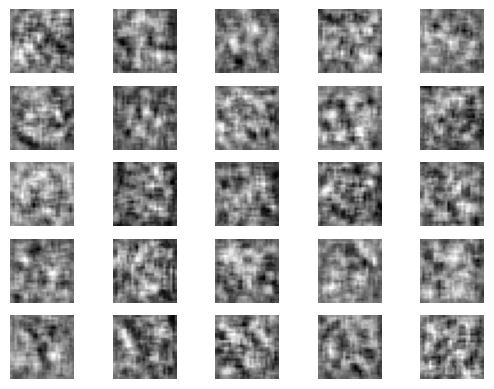

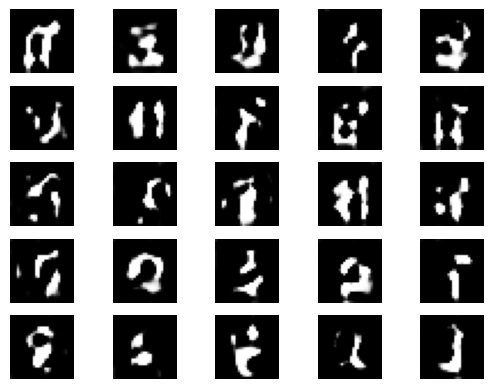

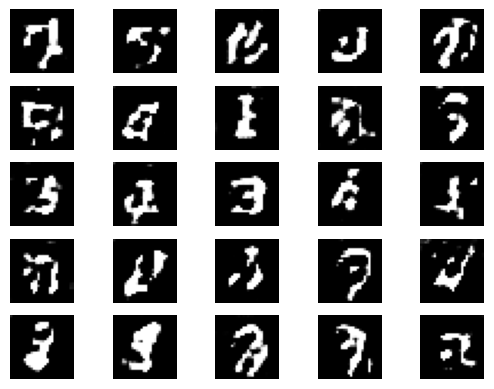

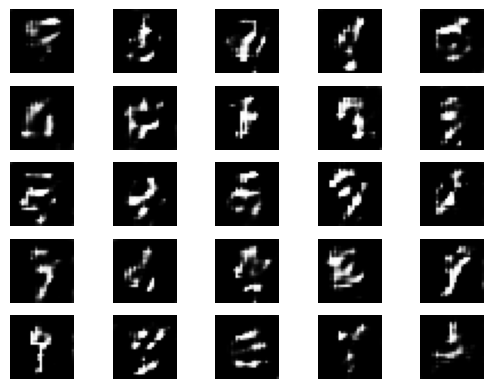

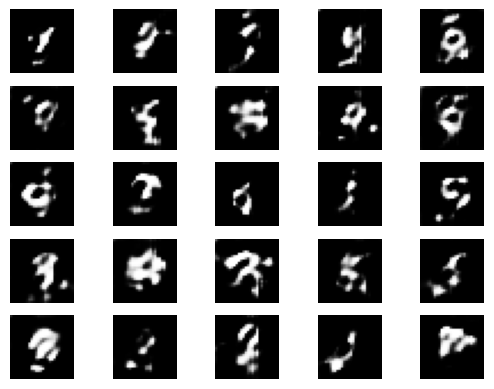

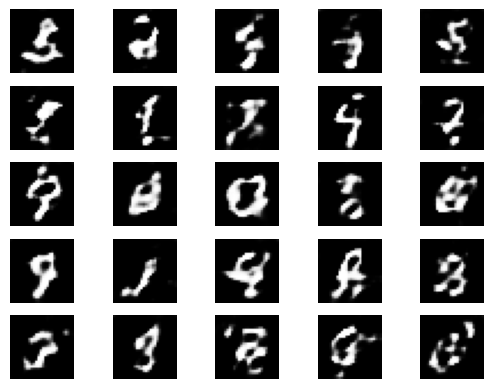

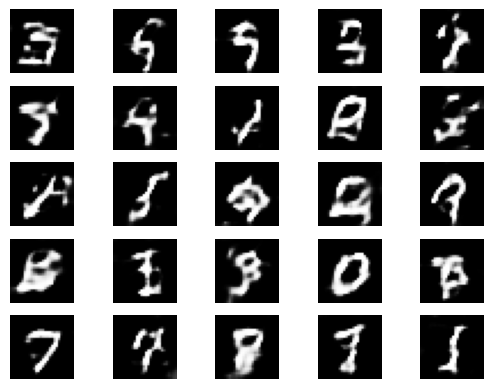

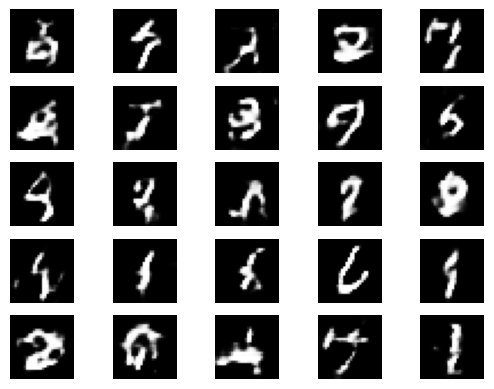

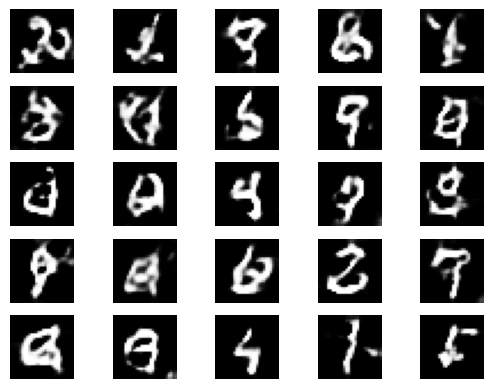

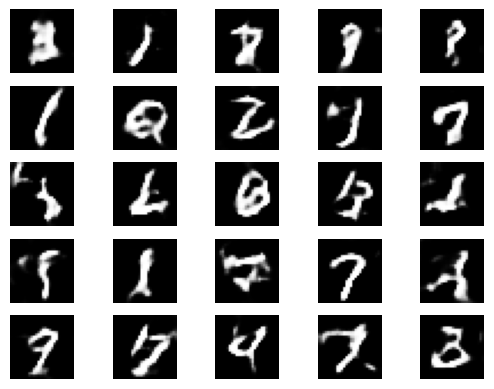

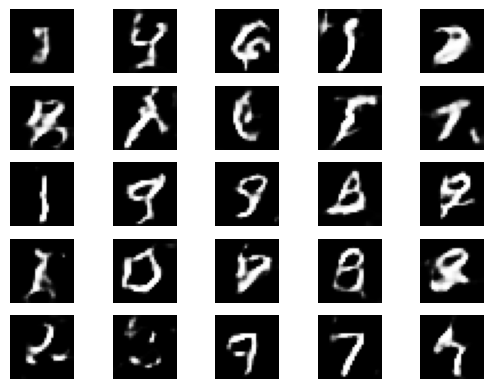

In [7]:
gan_train(2001, 32, 200)